In [23]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
from saif.crs_model.peakdetector import pk_indxs
plt.style.use('ggplot')

%matplotlib inline

### Load Data

In [24]:
SEISMIC_DATA = '../../../dataset_preparing/datasets_Jul_7/cushing_oklahoma/cushingSeismic.hdf5'
PRESSURE_DATA = '../../../dataset_preparing/datasets_Jul_7/cushing_oklahoma/cushingPressure.hdf5'

In [25]:
from orion_light import seismic_catalog
from orion_light import pressure_table

In [26]:
catalog = seismic_catalog.SeismicCatalog()
catalog.load_catalog_hdf5(SEISMIC_DATA)

In [27]:
pressure_model = pressure_table.PressureTableModel()
pressure_model.load_table(PRESSURE_DATA)

Loading pressure table from hdf5 file: ../../../dataset_preparing/datasets_Jul_7/cushing_oklahoma/cushingPressure.hdf5


### Process $N(t)$

- Pressure data and seismic events are recorded at different times.
    - First goal: Clip all data to the time interval where we have samples for both pressure and seismic activity
    - Second goal: linearly interpolate the seismic data so that the event times align with the pressure data.
    - Third goal: empirically compute the rate (numerical derivative), in order to define R0.
- Partition the data into **main shock** and **interseismic** regions.
    - This should be done by a peak detector, but right now it is done manually (by visual inspection).

In [28]:
from scipy.interpolate import interp1d

Obtain the time intervals for the seismic data, and creating the interpolator.

In [29]:
Mc = 1.6
catalog.set_slice(magnitude_range = [Mc, 10])
event_times = catalog.get_epoch_slice() 
start_t = event_times[0]
end_t = event_times[-1]
event_times = event_times / 86400 / 365.25

t_n = event_times - event_times[0]
n_cnts = np.arange(len(t_n))
n_func = interp1d(t_n, n_cnts, kind='linear')

In [30]:
catalog.

SyntaxError: invalid syntax (4000300365.py, line 1)

Obtain the time intervals for the pressure data, and interpolate the seismic data

In [31]:
t_p = pressure_epoch = pressure_model.table_data['t']
start_idx = np.where(t_p > start_t)[0][0]
end_idx = np.where(t_p > end_t)[0][0] - 1

t_p = t_p[start_idx:end_idx]
p = pressure_model.table_data['pressure'][1:][start_idx+1:end_idx]
dpdt = pressure_model.table_data['dpdt'][1:][start_idx+1:end_idx]

delta_t = t_p[1:] - t_p[:-1]

p = torch.FloatTensor(p)
dpdt = torch.FloatTensor(dpdt)
delta_t = torch.FloatTensor(delta_t)

t_p_interpolated = t_p / 86400 / 365.25 - event_times[0]
n_interpolated = n_func(t_p_interpolated) # interpolated number of earthquakes 

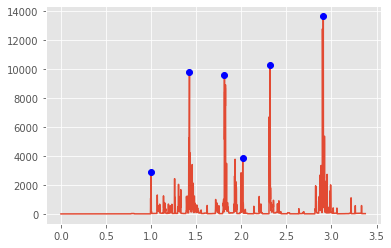

In [32]:
empirical_rate = np.gradient(n_interpolated, t_p_interpolated)
peak_indexs=pk_indxs(empirical_rate,trshd=0.2, min_dist=150)
plt.plot(t_p_interpolated, empirical_rate)
plt.plot(t_p_interpolated[peak_indexs],empirical_rate[peak_indexs],'o',color='b')
# plot peak earthquake events with big magnitude, maybe simpler way 

(1.5, 2.0)

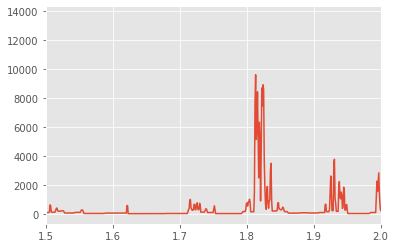

In [33]:
plt.plot(t_p_interpolated,empirical_rate)
plt.xlim([1.5,2])

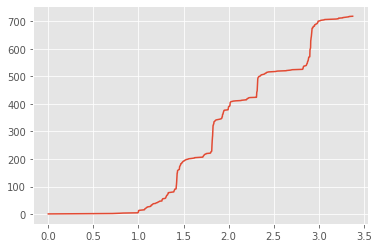

In [34]:
plt.plot(t_p_interpolated, n_interpolated)

Examining the first interseismic chunk (from t=0 years to t=1.3 years)

In [35]:
train_end_1 = np.where(t_p_interpolated > 1.3)[0][0] # cut-off time
# train_end = 1549

# train_start_2 = np.where(t_p_interpolated > 1.5)[0][0]
# fit from 1.3 to 1.75
train_end_2 = np.where(t_p_interpolated > 1.75)[0][0]


In [36]:
t_p_interpolated[train_end_2]

1.7500901437843837

In [37]:
n_target_1 = torch.FloatTensor(n_interpolated)[:train_end_1]
p_1 = torch.FloatTensor(p)[:train_end_1]
dpdt_1 = torch.FloatTensor(dpdt)[:train_end_1]
delta_t_1 = torch.FloatTensor(delta_t)[:train_end_1]

In [38]:
n_target_2 = torch.FloatTensor(n_interpolated)[train_start_2:train_end_2]
p_2 = torch.FloatTensor(p)[train_start_2:train_end_2]
dpdt_2 = torch.FloatTensor(dpdt)[train_start_2:train_end_2]
delta_t_2 = torch.FloatTensor(delta_t)[train_start_2:train_end_2]

In [39]:
p = pressure_model.table_data['pressure'][1:][start_idx+1:end_idx]
len(p_2) == len(n_target_2)

True

### Define site constants

In [40]:
mpa_yr2pa_s = 1e6 / 365.25 / 86400

site_info = {
    'tectonic_shear_stressing_rate' : 3.5e-4 * mpa_yr2pa_s, # Pa / s
    'tectonic_normal_stressing_rate' : 0, # Pa/s
    'sigma' : 30 * 1e6, # Pa
    'biot' : 0.3, # dimensionless
    #'background_rate' : 1.36 / 365.25 / 86400, # event/second,
    'background_rate' : empirical_rate[0] / 365.25 / 86400, # event/second,
    'init_delta_t' : delta_t[0].item()
}

### Sampling the grid

We keep the rate factor fixed, and examine the landscape for mu_minus_alpha and rate_coeff.

### Run Model

In [28]:
from saif.crs_model.model import CRSModel

In [29]:
model = CRSModel(site_info)

Visualize a sample

Define the criterion: MSELoss.

- Be careful: we may need to normalize the data before using MSELoss.
- In future, we might forecast rate (or, $\Delta N(t)$) since this is easier to bound than total number.

In [33]:
criterion = nn.MSELoss(reduction='sum')

In [35]:
import torch.optim as optim

# params = torch.FloatTensor([[0.5,1e-2,1e-4]])
params = torch.FloatTensor([[0.5,1e-2,1e-4]])
params.requires_grad=True #
params.register_hook(lambda g: F.normalize(g)) # some function that takes in gradients and adjusts it
# Here we use normalize from torch.functional

optimizer = optim.SGD(params=[params],lr=.0001,momentum=0.2)
# optimizer = optim.Adam(params=[params],lr=0.01)
criterion = nn.MSELoss(reduction='sum')

model = CRSModel(site_info)
Rt, Nt = model(params, p, dpdt, delta_t)
loss = criterion(Nt[:,1:], n_target_1[None,:])
loss.item()

In [36]:
# display(params.grad.data)

In [37]:
# Fitting the first interseismic
for step in range(200):
    Rt, Nt = model(params, p, dpdt, delta_t)
    # loss = criterion(Nt[:,1:], n_target[None,:]) # Need to define a loss function that compares with the real data
    # Define a MSE of forecasted number Nt with the ground truth
    optimizer.zero_grad()
    loss = criterion(Nt[:,1:].squeeze(), n_target[:])
    # print('loss is ' + str(loss.item()))
    # optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (step % 20 == 0):
        print("step: " + str(step))
        print("loss is " + str(loss.item()))
        # display(params)
        # display(params.grad.data) # showing the gradient
    
    if (loss.item() < 10000):
        optimizer=optim.SGD(params=[params],lr=.00001,momentum=0.2) # reduce the learning rate when loss is small
    

step: 0
loss is 1134726.25
step: 20
loss is 1056336.75
step: 40
loss is 781973.5
step: 60
loss is 70129.96875
step: 80
loss is 22439.365234375
step: 100
loss is 19761.94921875
step: 120
loss is 19502.328125
step: 140
loss is 19464.33203125
step: 160
loss is 19458.21875
step: 180
loss is 19456.95703125


In [38]:
# params_final = torch.FloatTensor([[5.0010e-01, 2.5500e-03, 1.5320e-04]]) # Final output
params_initial = torch.FloatTensor([[0.5,1e-2,1e-4]]) # Initialization
display(params)

tensor([[5.0009e-01, 2.7023e-03, 2.8020e-04]], requires_grad=True)

In [39]:
Rt, Nt = model(params, p, dpdt, delta_t)
loss = criterion(Nt[:,1:].squeeze(), n_target)
loss.data

tensor(19456.6562)

Text(0, 0.5, 'earthquake counts')

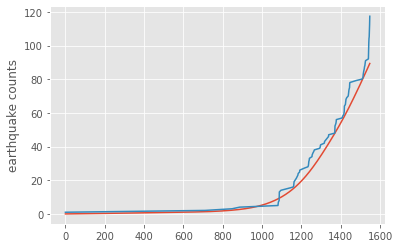

In [40]:
plt.plot(Nt[0,1:].detach().numpy())
plt.plot(n_target)
plt.xlabel('')
plt.ylabel('earthquake counts')

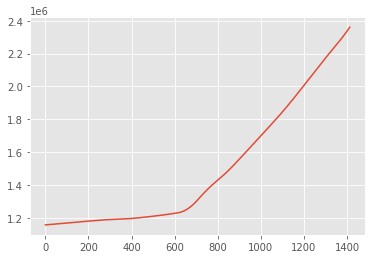

In [106]:
# fitting the second interseismic
params2 = torch.FloatTensor([[0.5,1e-2,1e-4]])
params2.requires_grad=True #
params2.register_hook(lambda g: F.normalize(g)) # some function that takes in gradients and adjusts it
# Here we use normalize from torch.functional

optimizer = optim.SGD(params=[params2],lr=.0001,momentum=0.2)
criterion = nn.MSELoss(reduction='sum')

model = CRSModel(site_info)
Rt, Nt = model(params2, p, dpdt, delta_t)

In [298]:
params

tensor([[5.0010e-01, 2.4322e-03, 2.4004e-04]], requires_grad=True)

## Adding Kalya's optimized parameters for comparison

tensor(6396.3408)

Text(0, 0.5, 'earthquake counts')

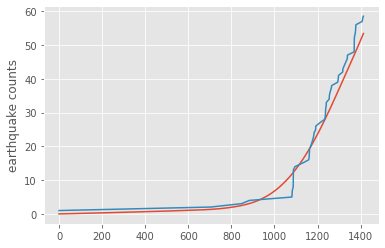

In [306]:
params_kayla = torch.FloatTensor([[0.575, 0.0026, 1.6e-4]]) # Parameters optimized by Kayla
Rt_kayla, Nt_kayla = model(params_kayla, p, dpdt, delta_t)
loss = criterion(Nt_kayla[:,1:].squeeze(), n_target)
display(loss.data)
plt.plot(Nt_kayla[0,1:].detach().numpy())
plt.plot(n_target)
plt.xlabel('')
plt.ylabel('earthquake counts')

tensor([ 1.0003,  1.0017,  1.0032,  ..., 58.1879, 58.3533, 58.5187])